# Benchmark analysis

We analyze the PBE0 benchmarks performed in platforms accelerated with PVC cards

In [1]:
from sys import path
path.insert(0,'../')
import benchmark

In [2]:
# from os.path import join
# #read the results and convert then into dataframes (may take a while)
# dfs={join(directory,nds): benchmark.dataframe(benchmark.extract_results(directory=join(directory,nds)))
#      for directory in ['UO2_2-CPU', 'UO2_2-GPU', 'UO2_2-SYCLCPU'] for nds in '1node  2node  4node  8node'.split()}    

In [3]:
# from pandas import concat
# df=concat(dfs.values())
# df.to_csv('pvc_benchs.csv')
# # df=concat(dfsc.values())
# # df.to_csv('cubic_benchs.csv')

## Load the benchmark data

In [4]:
from pandas import read_csv
df=read_csv('pvc_benchs.csv',index_col=0)

In [5]:
sub=benchmark.df_select(df,{0:'GPU'})

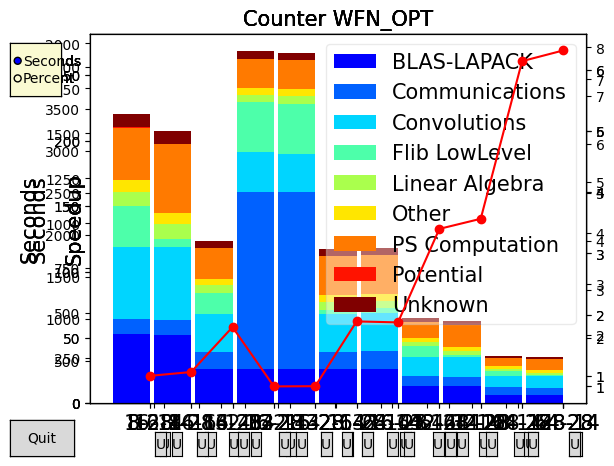

In [6]:
from futile import Time as T
from numpy import array
tt=T.TimeData(*sub.timefile,plottype='Seconds')
cores=[224,448,896,1792]
archs=['-CPU', 'SYCLCPU', 'GPU']
alldata={}
mask={'-CPU':[1,3,5,7],'SYCLCPU':[1,5,7,9],'GPU':[1,6,8,10]}
for arch in archs:
    sub=benchmark.df_select(df,{0:arch})
    tt=T.TimeData(*sub.timefile,plottype='Seconds')
    alldata[arch]=([(k,v[mask[arch]])for k, v in tt.actual_data[0]],array(tt.actual_data[1])[mask[arch]])


In [7]:
cores=[224,448,896,1792]
dt={k:{a:b for a,b in v[0]}for k, v in alldata.items()}
datat={}
for i,core in enumerate(cores):
    for d in dt.values():
        for k,v in d.items():
            datat.setdefault(core,{}).setdefault(k,[]).append(v[i])

In [8]:
alldatat={c:([(k,array(v)) for k,v in datat[c].items()],[v[1][i] for v in alldata.values()]) for i,c in enumerate(cores)}

In [9]:
def for_table(dfs,time,ideal,speedup,efficiency):
    from pandas import DataFrame
    return DataFrame({
        'Nat': dfs.Nat,
        'MPI':dfs.MPI,
        'OMP':dfs.OMP,
        'cores':dfs.cores,
        'time':time,
        'ideal time':ideal,
        'Speedup':speedup,
        'Eff.':efficiency})

def weak_scaling(ax,dfs,x='cores',y='Walltime',marker='o-'):
    from numpy import argmin
    c=dfs[x]
    t=dfs[y]
    im=0#argmin(t)
    ideal_su=c/c[im]
    ideal=t[im]
    eff=ideal/t
    #print(len(eff),eff[-1],max(eff),min(eff))
    if len(eff) <=1:
        return
    ax.semilogx(c,t,marker)
    ax.axhline(ideal,c='k',lw=1)
    return for_table(dfs,t,ideal,1,eff)
def strong_scaling(ax,dfs,x='cores',y='Walltime',marker='o-',**kwargs):
    from numpy import argmax,argmin
    c=dfs[x]
    t=dfs[y]
    im=argmax(t)
    ideal_su=c/c[im]
    ideal=t[im]*(c[im]/c)
    su=t[im]/t
    eff=ideal/t
    #print(len(eff),eff[-1],max(eff),min(eff))
    # if min(eff) < 0.65 or max(eff) > 1.1:
    #    return
    ax.loglog(c,t,marker,**kwargs)
    ax.loglog(c,ideal,c='k')
    return for_table(dfs,t,ideal,su,eff)

/tmp/ipykernel_17867/3988252844.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ideal_su=c/c[im]
/tmp/ipykernel_17867/3988252844.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ideal=t[im]*(c[im]/c)
/tmp/ipykernel_17867/3988252844.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  su=t[im]/t


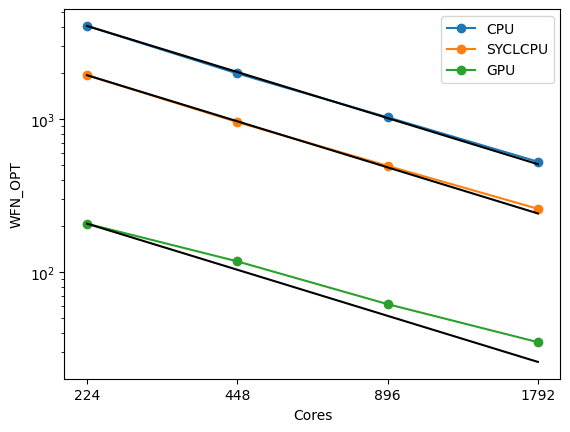

In [10]:
from matplotlib import ticker, pyplot as plt
fig,ax=plt.subplots()
col='WFN_OPT'
dfts=[]
archs=['-CPU', 'SYCLCPU', 'GPU']
for name,dft in [(a,benchmark.df_select(df,{0:a}))
                 for a in archs]:
    dfts.append(strong_scaling(ax,dft,y=col,label=name.lstrip('-')))
ax.set_xticks([224,448,896,1792])
ax.set_xticks([],minor=True)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Cores')
ax.set_ylabel(col)
_=ax.legend(loc='best')

In [11]:
from pandas import read_csv
cuda=read_csv('/work/dossiers/projects/Max3/PBEvsPBE0.csv',index_col=0)

In [12]:
cuda

Communications  Linear Algebra  BigDFT internal routines  \
PBE                         14.0            19.3                      6.99   
PBE0 - CPU                  96.0            19.3                     40.70   
PBE0 - GPU                  89.0            19.3                     11.40   
PBE0 - GPUDirect           116.0            19.3                      7.19   

                  Convolutions  Exact Exchange  
PBE                        4.2        0.020691  
PBE0 - CPU                 4.2      518.251800  
PBE0 - GPU                 4.2      277.780730  
PBE0 - GPUDirect           4.2        9.297890

In [13]:
from numpy import array
cdata=([(k,array(v)) for k,v in cuda.items()],cuda.T.sum())

In [14]:
def barplot(ids,dt,aggregate,ax):
    data=dt[1]
    labels=[round(max(data)/d,1) for d in data]
    benchmark.draw_barplot(ids,dt,aggregate=aggregate,annotations=labels,ax=ax,colors=['#2ED4CE', '#FF0000', 'white','#D4D4D4'] )

In [15]:
mask=[1,3]
cdatat=([(k,v[mask])for k, v in cdata[0]],array(cdata[1])[mask])

In [16]:
aggregate=[('Communications',['Communications']),
           ('FFT & Convolutions',['Convolutions','PS Computation','Potential']),
           ('Linear Algebra',['BLAS-LAPACK', 'Linear Algebra']),
           ('Other',['Flib LowLevel','Unknown', 'Other'])]
aggregate_cuda=[('Communications',['Communications']),
           ('FFT & Convolutions',['Convolutions','Exact Exchange']),
           ('Linear Algebra',['Linear Algebra']),
           ('Other',['BigDFT internal routines'])]

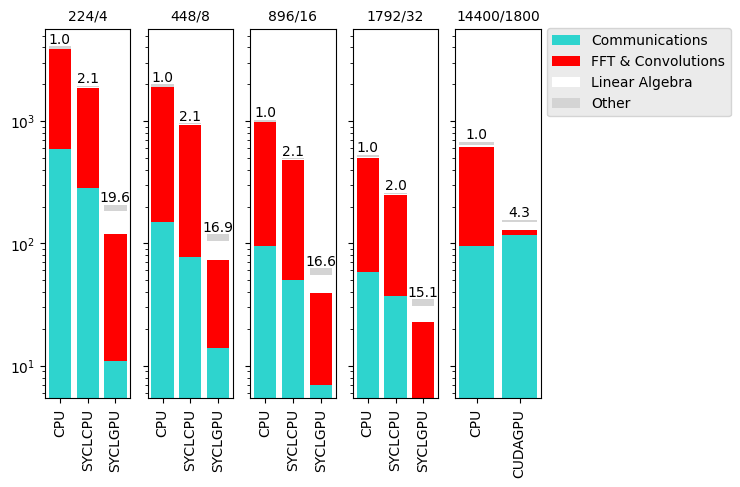

In [20]:
from matplotlib.patches import ConnectionPatch
fig, axs = plt.subplots(1,5,sharey=True)
nds=['CPU','SYCLCPU','SYCLGPU']
for (cores,dt),ax in zip(alldatat.items(),axs[:4]):
    barplot(nds,dt,aggregate,ax)
    ax.set_title(str(cores)+'/'+str(int(cores/224)*4),fontsize=10)
    ax.set_yscale('log')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax=axs[4]
barplot(['CPU','CUDAGPU'],cdatat,aggregate_cuda,ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title(str(14400)+'/'+str(int(1800)),fontsize=10)
lgd=ax.legend(bbox_to_anchor=(3.3,1.02),facecolor='0.9')
fig.savefig('PBE0.png',bbox_extra_artists=(lgd,), bbox_inches='tight')